<a href="https://colab.research.google.com/github/ShFANI/ShFANI.github.io/blob/main/Multi_Offer_Uplift_Modeling_for_Incremental_Conversions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multi-Offer Uplift Modeling for Incremental Conversions

This notebook explain the works on the (**Uplift Modeling & Qini Curve with Python**) to a **multi-offer** promotion dataset:
- **No Offer** (control)
- **Discount**
- **Buy One Get One (BOGO)**

## Business questions
1) **Is each promotion incremental?** (Discount vs No Offer, BOGO vs No Offer)
2) **Who should we target** to maximize **incremental conversions**?
3) **Which offer** (Discount or BOGO) should we send to each customer?

## Modeling approach (Indirect uplift)
We implement **S‑Learner, T‑Learner, X‑Learner** (binary uplift) in a **one‑vs‑control** setup:
- Uplift for **Discount vs No Offer**
- Uplift for **BOGO vs No Offer**

Then we choose the best action per customer: **max positive uplift** → send that offer, else **No Offer**.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

print("Ready: numpy/pandas/sklearn/matplotlib imported.")

Ready: numpy/pandas/sklearn/matplotlib imported.


## 1) Load data
Upload the ZIP that contains the Kaggle CSV (e.g., `data.csv.zip`).


In [3]:
import os, glob, zipfile
import pandas as pd

DATA_PATH = ""

def in_colab():
    try:
        import google.colab
        return True
    except Exception:
        return False

if in_colab():
    from google.colab import files
    uploaded = files.upload()
    print("Uploaded:", list(uploaded.keys()))
    zip_name = next((k for k in uploaded.keys() if k.lower().endswith(".zip")), None)
    if zip_name is None:
        raise ValueError("Please upload a .zip file that contains a .csv.")
    extract_dir = "/content/uplift_zip"
    os.makedirs(extract_dir, exist_ok=True)
    with zipfile.ZipFile(zip_name, "r") as z:
        z.extractall(extract_dir)
    csvs = glob.glob(extract_dir + "/**/*.csv", recursive=True)
    if len(csvs) == 0:
        raise ValueError("No CSV found inside the ZIP.")
    DATA_PATH = csvs[0]
    print("Using CSV:", DATA_PATH)
else:
    if not DATA_PATH:
        raise ValueError("Not running in Colab. Please set DATA_PATH in this cell to your CSV path.")

df = pd.read_csv(DATA_PATH)
display(df.head())
print("Shape:", df.shape)
print("Columns:", df.columns.tolist())

Saving data.csv.zip to data.csv.zip
Uploaded: ['data.csv.zip']
Using CSV: /content/uplift_zip/data.csv


,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0
3,9,675.83,1,0,Rural,1,Web,Discount,0
4,2,45.34,1,0,Urban,0,Web,Buy One Get One,0


Shape: (64000, 9)
Columns: ['recency', 'history', 'used_discount', 'used_bogo', 'zip_code', 'is_referral', 'channel', 'offer', 'conversion']


## 2) Identify columns + quick EDA
This dataset includes `offer` and `conversion`.
We plot conversion rate by offer, and confirm the offer levels.


offer_col: offer | y_col: conversion
offer
Buy One Get One    21387
Discount           21307
No Offer           21306
Name: count, dtype: int64


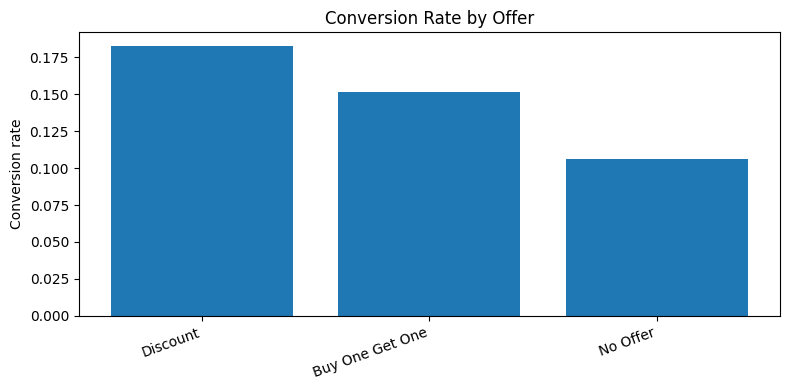

In [4]:

import numpy as np
import matplotlib.pyplot as plt

cols_lower = {c.lower(): c for c in df.columns}
offer_col = cols_lower.get("offer", None)
y_col = cols_lower.get("conversion", None)

# Manual overrides if needed:
# offer_col = "offer"
# y_col = "conversion"

if offer_col is None or y_col is None:
    raise ValueError("Couldn't detect 'offer' and/or 'conversion'. Set offer_col/y_col manually in this cell.")

df[offer_col] = df[offer_col].astype(str)
df["y"] = df[y_col].astype(int)

print("offer_col:", offer_col, "| y_col:", y_col)
print(df[offer_col].value_counts(dropna=False))

cr = df.groupby(offer_col)["y"].mean().sort_values(ascending=False)
plt.figure(figsize=(8,4))
plt.bar(cr.index.astype(str), cr.values)
plt.title("Conversion Rate by Offer")
plt.ylabel("Conversion rate")
plt.xticks(rotation=20, ha="right")
plt.tight_layout()
plt.show()


## 3) Business Q1 — Is each promotion incremental?
We estimate population-level incrementality using lift vs control.


In [5]:

import pandas as pd

offer_vals = df[offer_col].str.lower()
control_mask = offer_vals.str.contains("no")  # "no offer"
if control_mask.mean() == 0:
    raise ValueError("Couldn't find 'No Offer' rows. Check offer values.")

control_cr = df.loc[control_mask, "y"].mean()
n_control = int(control_mask.sum())

rows = []
# match Discount + BOGO variants
treat_defs = {"Discount": "discount", "BOGO": "buy one get one|bogo"}

for label, regex in treat_defs.items():
    m = offer_vals.str.contains(regex)
    if m.sum() == 0:
        continue
    cr_offer = df.loc[m, "y"].mean()
    lift = cr_offer - control_cr
    inc_conv = lift * int(m.sum())
    rows.append({
        "Offer": label,
        "CR_offer": float(cr_offer),
        "CR_control": float(control_cr),
        "Lift": float(lift),
        "N_offer": int(m.sum()),
        "N_control": n_control,
        "IncConversions_in_offer_group": float(inc_conv)
    })

summary = pd.DataFrame(rows).sort_values("Lift", ascending=False)
display(summary)

print(f"Control (No Offer) conversion rate: {control_cr:.4f} (n={n_control})")


,Offer,CR_offer,CR_control,Lift,N_offer,N_control,IncConversions_in_offer_group
0,Discount,0.182757,0.106167,0.076590,21307,21306,1631.893833
1,BOGO,0.151400,0.106167,0.045233,21387,21306,967.400451


Control (No Offer) conversion rate: 0.1062 (n=21306)


### Interpretation (incrementality / ATE)

- **CR_control** is the baseline conversion rate for **No Offer**.
- For each promotion, **Lift = CR_offer − CR_control**.
- **IncConversions_in_offer_group = Lift × N_offer** estimates how many *extra* conversions occurred in that offer group compared to what we'd expect if they behaved like control.

If Lift is positive, the promotion is **incremental on average** (it increases conversions relative to no offer).  
Next we move from **average lift (ATE)** to **uplift modeling (CATE)**: *who* should receive each promotion.

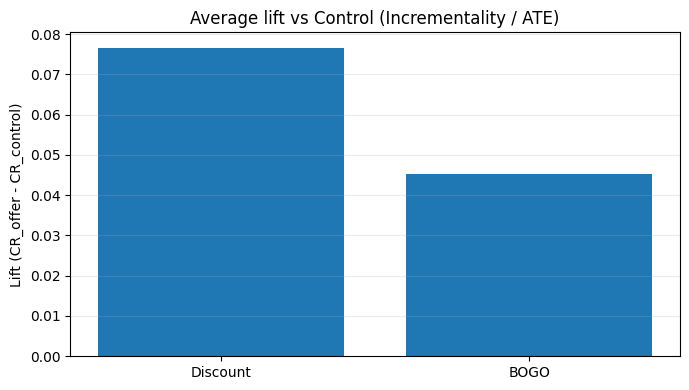

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,4))
plt.bar(summary["Offer"], summary["Lift"])
plt.title("Average lift vs Control (Incrementality / ATE)")
plt.ylabel("Lift (CR_offer - CR_control)")
plt.grid(True, axis="y", alpha=0.25)
plt.tight_layout()
plt.show()

## 4) Create binary uplift datasets (one‑vs‑control)
We build two binary datasets:
- Discount vs No Offer
- BOGO vs No Offer


In [7]:

def prepare_binary_dataset(df, offer_regex, offer_col):
    offer_vals = df[offer_col].astype(str).str.lower()
    control = offer_vals.str.contains("no")
    treated = offer_vals.str.contains(offer_regex)
    sub = df.loc[control | treated].copy()
    sub["t"] = treated.loc[sub.index].astype(int)
    return sub

df_disc = prepare_binary_dataset(df, "discount", offer_col)
df_bogo = prepare_binary_dataset(df, "buy one get one|bogo", offer_col)

print("Discount vs control:", df_disc.shape, "treat rate:", df_disc["t"].mean())
print("BOGO vs control:", df_bogo.shape, "treat rate:", df_bogo["t"].mean())


Discount vs control: (42613, 11) treat rate: 0.5000117335085538
BOGO vs control: (42693, 11) treat rate: 0.5009486332654065


## 5) Preprocess features + train/test split
We one-hot encode categoricals and stratify the split by 4-class CN/CR/TN/TR to keep balance.


In [8]:

from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

def make_group4(t, y):
    if t==0 and y==0: return "CN"
    if t==0 and y==1: return "CR"
    if t==1 and y==0: return "TN"
    return "TR"

def preprocess_for_uplift(sub_df, offer_col, y_col):
    base = sub_df.copy()
    base["ybin"] = base[y_col].astype(int)
    t = base["t"].values
    y = base["ybin"].values

    # Drop columns that leak labels
    drop_cols = [offer_col, y_col, "y", "t", "ybin"]
    X = base.drop(columns=[c for c in drop_cols if c in base.columns]).copy()

    cat_cols = [c for c in X.columns if X[c].dtype == "object"]
    X_enc = pd.get_dummies(X, columns=cat_cols, drop_first=False)

    g4 = np.array([make_group4(tt, yy) for tt, yy in zip(t, y)])

    X_train, X_test, t_train, t_test, y_train, y_test = train_test_split(
        X_enc, t, y, test_size=0.25, random_state=42, stratify=g4
    )
    return X_train, X_test, t_train, t_test, y_train, y_test

Xtr_d, Xte_d, ttr_d, tte_d, ytr_d, yte_d = preprocess_for_uplift(df_disc, offer_col, y_col)
Xtr_b, Xte_b, ttr_b, tte_b, ytr_b, yte_b = preprocess_for_uplift(df_bogo, offer_col, y_col)

print("Discount X:", Xtr_d.shape, Xte_d.shape)
print("BOGO X:", Xtr_b.shape, Xte_b.shape)


Discount X: (31959, 11) (10654, 11)
BOGO X: (32019, 11) (10674, 11)


## 6) Train indirect uplift models: S / T / X learners
We use a GradientBoostingClassifier as the base learner (fast, strong for tabular data).


In [9]:
import copy
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.linear_model import LogisticRegression

# ------------------------------------------------------------
# Indirect uplift learners implemented with scikit-learn only
# (No causalml dependency, so the notebook runs everywhere.)
# ------------------------------------------------------------

def s_learner_uplift(base_clf, X_train, t_train, y_train, X_test):
    # Fit one model on [X, t] -> y
    Xt = X_train.copy()
    Xt["__t__"] = t_train
    model = copy.deepcopy(base_clf)
    model.fit(Xt, y_train)

    X1 = X_test.copy(); X1["__t__"] = 1
    X0 = X_test.copy(); X0["__t__"] = 0
    p1 = model.predict_proba(X1)[:, 1]
    p0 = model.predict_proba(X0)[:, 1]
    return model, (p1 - p0)

def t_learner_uplift(base_clf, X_train, t_train, y_train, X_test):
    # Fit separate models on treated and control
    m1 = copy.deepcopy(base_clf)
    m0 = copy.deepcopy(base_clf)

    X1_tr = X_train[t_train==1]
    y1_tr = y_train[t_train==1]
    X0_tr = X_train[t_train==0]
    y0_tr = y_train[t_train==0]

    m1.fit(X1_tr, y1_tr)
    m0.fit(X0_tr, y0_tr)

    p1 = m1.predict_proba(X_test)[:, 1]
    p0 = m0.predict_proba(X_test)[:, 1]
    return (m0, m1), (p1 - p0)

def x_learner_uplift(base_clf, base_reg, X_train, t_train, y_train, X_test):
    # X-learner (Künzel et al.) — a practical implementation
    # 1) outcome models mu0, mu1 (like T-learner)
    (m0, m1), _ = t_learner_uplift(base_clf, X_train, t_train, y_train, X_train)

    # 2) impute treatment effects
    # Treated: D1 = y1 - mu0(X1)
    mu0_on_treated = m0.predict_proba(X_train[t_train==1])[:, 1]
    D1 = y_train[t_train==1] - mu0_on_treated

    # Control: D0 = mu1(X0) - y0
    mu1_on_control = m1.predict_proba(X_train[t_train==0])[:, 1]
    D0 = mu1_on_control - y_train[t_train==0]

    # 3) fit tau models on imputed effects
    tau1 = copy.deepcopy(base_reg)
    tau0 = copy.deepcopy(base_reg)
    tau1.fit(X_train[t_train==1], D1)
    tau0.fit(X_train[t_train==0], D0)

    # 4) propensity model g(x) = P(T=1|X)
    g = LogisticRegression(max_iter=2000)
    g.fit(X_train, t_train)
    gx = g.predict_proba(X_test)[:, 1]

    # 5) combine
    uplift = gx * tau0.predict(X_test) + (1 - gx) * tau1.predict(X_test)
    return {"mu0": m0, "mu1": m1, "tau0": tau0, "tau1": tau1, "g": g}, uplift

# base learners
base_clf = GradientBoostingClassifier(random_state=42)
base_reg = GradientBoostingRegressor(random_state=42)

def fit_learners(X_train, t_train, y_train, X_test):
    # S
    s_model, upl_s = s_learner_uplift(base_clf, X_train, t_train, y_train, X_test)
    # T
    t_models, upl_t = t_learner_uplift(base_clf, X_train, t_train, y_train, X_test)
    # X
    x_models, upl_x = x_learner_uplift(base_clf, base_reg, X_train, t_train, y_train, X_test)
    return (s_model, t_models, x_models), (upl_s, upl_t, upl_x)

(models_d, preds_d) = fit_learners(Xtr_d, ttr_d, ytr_d, Xte_d)
(models_b, preds_b) = fit_learners(Xtr_b, ttr_b, ytr_b, Xte_b)

upl_s_d, upl_t_d, upl_x_d = preds_d
upl_s_b, upl_t_b, upl_x_b = preds_b

print("Trained S/T/X learners for Discount and BOGO (no causalml).")

Trained S/T/X learners for Discount and BOGO (no causalml).


## 7) Qini evaluation (does the model find incremental responders?)
We compute Qini AUC and plot Qini curves for each learner.


/tmp/ipython-input-303/809390654.py:29: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return float(np.trapz(q0, x0))


Qini AUC — Discount vs Control: {'S': 218.67993541570192, 'T': 219.6270093948167, 'X': 211.70007016170604}
Qini AUC — BOGO vs Control: {'S': 167.90529797470958, 'T': 166.8759584479249, 'X': 165.55666852489907}


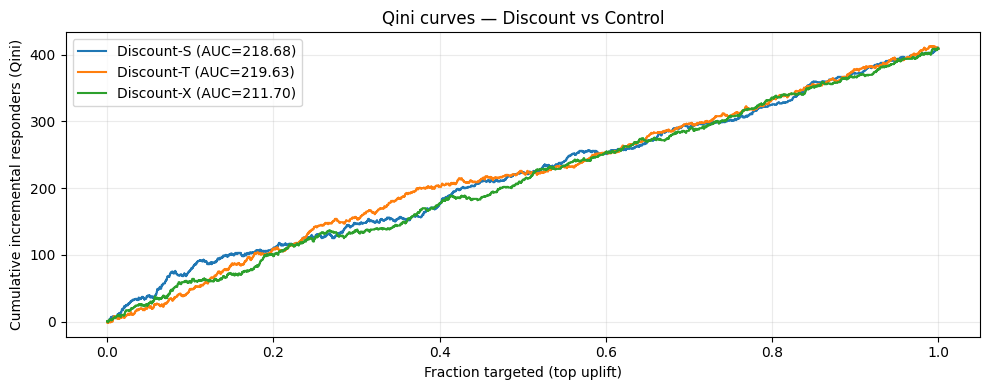

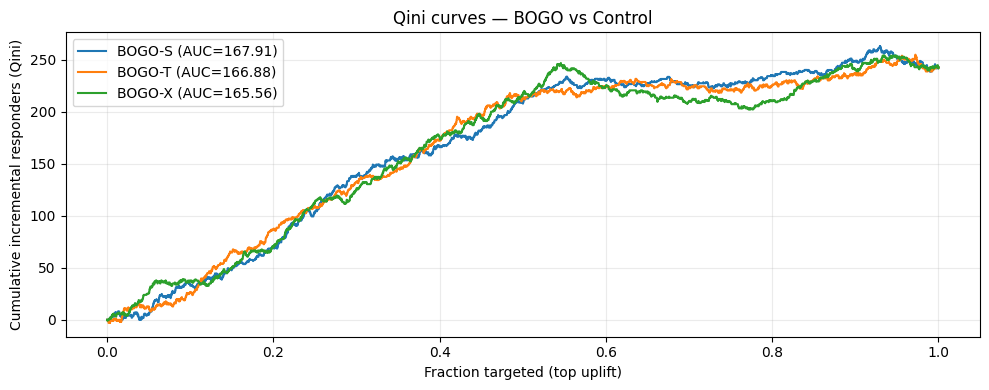

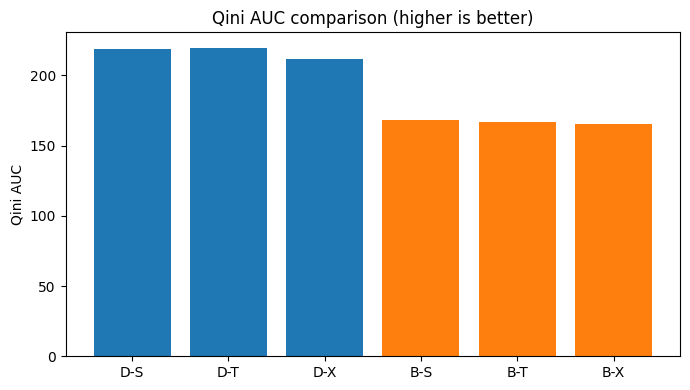

In [10]:
import numpy as np
import matplotlib.pyplot as plt

def qini_curve_points(y, t, uplift):
    y = np.asarray(y)
    t = np.asarray(t)
    uplift = np.asarray(uplift)

    order = np.argsort(-uplift)
    y_ord = y[order]
    t_ord = t[order]

    N_t = (t==1).sum()
    N_c = (t==0).sum()
    ratio = N_t / max(N_c, 1)

    cum_tr = np.cumsum((t_ord==1) & (y_ord==1))
    cum_cr = np.cumsum((t_ord==0) & (y_ord==1))

    qini = cum_tr - ratio * cum_cr
    x = np.arange(1, len(qini)+1) / len(qini)
    return x, qini

def qini_auc(y, t, uplift):
    x, q = qini_curve_points(y, t, uplift)
    # include (0,0)
    x0 = np.concatenate([[0], x])
    q0 = np.concatenate([[0], q])
    return float(np.trapz(q0, x0))

preds_disc = {"S": upl_s_d, "T": upl_t_d, "X": upl_x_d}
preds_bogo = {"S": upl_s_b, "T": upl_t_b, "X": upl_x_b}

qini_disc = {k: qini_auc(yte_d, tte_d, v) for k, v in preds_disc.items()}
qini_bogo = {k: qini_auc(yte_b, tte_b, v) for k, v in preds_bogo.items()}

print("Qini AUC — Discount vs Control:", qini_disc)
print("Qini AUC — BOGO vs Control:", qini_bogo)

# Plot Qini curves (per offer)
plt.figure(figsize=(10,4))
for k, v in preds_disc.items():
    x, q = qini_curve_points(yte_d, tte_d, v)
    plt.plot(x, q, label=f"Discount-{k} (AUC={qini_disc[k]:.2f})")
plt.title("Qini curves — Discount vs Control")
plt.xlabel("Fraction targeted (top uplift)")
plt.ylabel("Cumulative incremental responders (Qini)")
plt.legend()
plt.grid(True, alpha=0.25)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,4))
for k, v in preds_bogo.items():
    x, q = qini_curve_points(yte_b, tte_b, v)
    plt.plot(x, q, label=f"BOGO-{k} (AUC={qini_bogo[k]:.2f})")
plt.title("Qini curves — BOGO vs Control")
plt.xlabel("Fraction targeted (top uplift)")
plt.ylabel("Cumulative incremental responders (Qini)")
plt.legend()
plt.grid(True, alpha=0.25)
plt.tight_layout()
plt.show()

# Bar chart for easy comparison
plt.figure(figsize=(7,4))
labels = ["S","T","X"]
plt.bar([f"D-{l}" for l in labels], [qini_disc[l] for l in labels])
plt.bar([f"B-{l}" for l in labels], [qini_bogo[l] for l in labels])
plt.title("Qini AUC comparison (higher is better)")
plt.ylabel("Qini AUC")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

## 8) Business Q2 — Who should we target?
Pick the best learner (highest Qini AUC) for each offer, then rank customers by uplift and compute incremental responders at top‑K cutoffs.


Best learner — Discount: T QiniAUC: 219.6270093948167
Best learner — BOGO: S QiniAUC: 167.90529797470958

Targeting table (Discount):


,Top_K,Customers,Cum_Inc_Responders
0,0.05,533,21.982726
1,0.10,1066,47.967706
2,0.20,2131,107.942546
3,0.30,3197,154.924521
4,0.50,5327,222.880961
5,1.00,10654,408.787833



Targeting table (BOGO):


,Top_K,Customers,Cum_Inc_Responders
0,0.05,534,4.834773
1,0.10,1068,32.686068
2,0.20,2135,70.463012
3,0.30,3203,139.252347
4,0.50,5337,208.748404
5,1.00,10674,242.666166


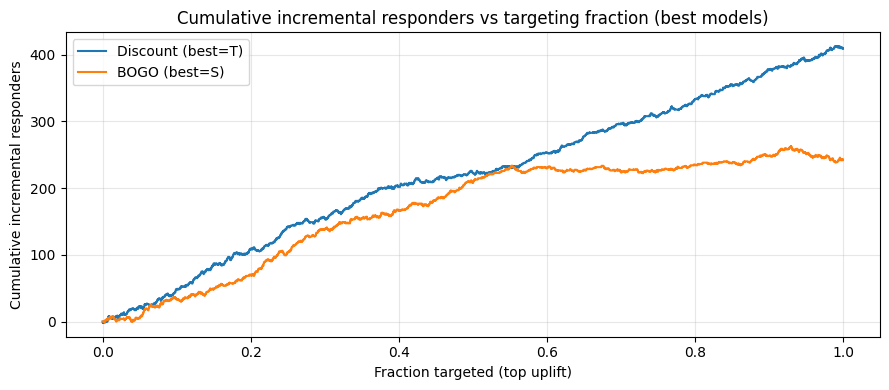

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def targeting_table(y, t, uplift, cutoffs=(0.05,0.10,0.20,0.30,0.50,1.0)):
    x, q = qini_curve_points(y, t, uplift)
    rows=[]
    n=len(q)
    for k in cutoffs:
        m=int(np.ceil(k*n))
        rows.append({"Top_K":k, "Customers":m, "Cum_Inc_Responders": float(q[m-1])})
    return pd.DataFrame(rows), x, q

best_disc = max(qini_disc, key=qini_disc.get)
best_bogo = max(qini_bogo, key=qini_bogo.get)

best_pred_disc = preds_disc[best_disc]
best_pred_bogo = preds_bogo[best_bogo]

print("Best learner — Discount:", best_disc, "QiniAUC:", qini_disc[best_disc])
print("Best learner — BOGO:", best_bogo, "QiniAUC:", qini_bogo[best_bogo])

tbl_disc, x_d, q_d = targeting_table(yte_d, tte_d, best_pred_disc)
tbl_bogo, x_b, q_b = targeting_table(yte_b, tte_b, best_pred_bogo)

print("\nTargeting table (Discount):")
display(tbl_disc)
print("\nTargeting table (BOGO):")
display(tbl_bogo)

plt.figure(figsize=(9,4))
plt.plot(x_d, q_d, label=f"Discount (best={best_disc})")
plt.plot(x_b, q_b, label=f"BOGO (best={best_bogo})")
plt.title("Cumulative incremental responders vs targeting fraction (best models)")
plt.xlabel("Fraction targeted (top uplift)")
plt.ylabel("Cumulative incremental responders")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 9) Business Q3 — Which offer should we send?
In production, you score the **same customers** with both uplift models and choose:
- Discount if uplift_Discount is highest and positive
- BOGO if uplift_BOGO is highest and positive
- Otherwise No Offer

Below we show the policy logic on **a shared feature table** built from the full dataset.


In [12]:
import numpy as np
import pandas as pd

# ------------------------------------------------------------
# Multi-offer policy: score the SAME customers for both offers
# using the best learner for each (by Qini AUC).
# Policy:
#   - send the offer with the larger positive uplift
#   - if both uplifts <= 0 -> No Offer
# ------------------------------------------------------------

# Build a unified feature matrix (drop offer + outcome)
X_all = df.drop(columns=[c for c in [offer_col, y_col, "y"] if c in df.columns]).copy()
cat_cols = [c for c in X_all.columns if X_all[c].dtype == "object"]
X_all_enc = pd.get_dummies(X_all, columns=cat_cols, drop_first=False)

# Align columns to each task's training columns
X_all_d = X_all_enc.reindex(columns=Xtr_d.columns, fill_value=0)
X_all_b = X_all_enc.reindex(columns=Xtr_b.columns, fill_value=0)

def predict_uplift_for_best(offer, best_key, X_aligned):
    if offer == "Discount":
        s_model, t_models, x_models = models_d
    else:
        s_model, t_models, x_models = models_b

    if best_key == "S":
        # S-learner uses "__t__"
        X1 = X_aligned.copy(); X1["__t__"] = 1
        X0 = X_aligned.copy(); X0["__t__"] = 0
        p1 = s_model.predict_proba(X1)[:,1]
        p0 = s_model.predict_proba(X0)[:,1]
        return p1 - p0

    if best_key == "T":
        m0, m1 = t_models
        p1 = m1.predict_proba(X_aligned)[:,1]
        p0 = m0.predict_proba(X_aligned)[:,1]
        return p1 - p0

    if best_key == "X":
        m0 = x_models["mu0"]; m1 = x_models["mu1"]
        tau0 = x_models["tau0"]; tau1 = x_models["tau1"]; g = x_models["g"]
        gx = g.predict_proba(X_aligned)[:,1]
        uplift = gx * tau0.predict(X_aligned) + (1-gx)*tau1.predict(X_aligned)
        return uplift

    raise ValueError("Unknown learner key.")

uplift_discount_all = predict_uplift_for_best("Discount", best_disc, X_all_d)
uplift_bogo_all     = predict_uplift_for_best("BOGO", best_bogo, X_all_b)

policy = np.where(
    (uplift_discount_all > uplift_bogo_all) & (uplift_discount_all > 0), "Discount",
    np.where((uplift_bogo_all > uplift_discount_all) & (uplift_bogo_all > 0), "BOGO", "No Offer")
)

policy_df = pd.DataFrame({
    "uplift_discount": uplift_discount_all,
    "uplift_bogo": uplift_bogo_all,
    "recommended_offer": policy
})

display(policy_df["recommended_offer"].value_counts())

# Show a few examples (highest uplift)
display(policy_df.sort_values("uplift_discount", ascending=False).head(10))

,count
recommended_offer,
Discount,51372
BOGO,12459
No Offer,169


,uplift_discount,uplift_bogo,recommended_offer
15808,0.713361,-0.003826,Discount
38680,0.687801,-0.007145,Discount
13818,0.674722,-0.015268,Discount
4579,0.659307,-0.000766,Discount
44047,0.604404,-0.010732,Discount
1631,0.578267,0.001392,Discount
5578,0.487900,-0.001360,Discount
57645,0.457228,0.063955,Discount
30038,0.456169,0.009565,Discount
54923,0.424132,0.008697,Discount


## 10) Stakeholder-ready answers
**Was it incremental?**
- Use Section 3: if Lift > 0 vs No Offer, the offer is incremental on average.

**Who to target?**
- Use Section 8: target top K% uplift customers (choose K where gains flatten).

**Which offer?**
- Use Section 9: score both offers and choose the max positive uplift.
